# Prediction of transdiagnostic factors - Follow up sample

## Analysis overview

#### Discovery sample

1. Model fitting: [`Model fitting - Discovery.ipynb`](<../../notebooks/discovery/Model fitting - Discovery.ipynb>)
2. Confidence analysis: [`Confidence analysis - Discovery.ipynb`](<../../notebooks/discovery/Confidence analysis - Discovery.ipynb>)
3. Transdiagnostic factor estimation: [`Transdiagnostic factors - Discovery.ipynb`](<../../notebooks/discovery/Transdiagnostic factors - Discovery.ipynb>)
4. Symptom-behaviour analyses: [`Symptom analyses - Discovery.ipynb`](<../../notebooks/discovery/Symptom analyses - Discovery.ipynb>)

#### Replication sample

1. Model fitting: [`Model fitting - Replication.ipynb`](<../../notebooks/replication/Model fitting - Replication.ipynb>)
2. Confidence analysis: [`Confidence analysis - Replication.ipynb`](<../../notebooks/replication/Confidence analysis - Replication.ipynb>)
3. Two-step task analysis: [`Two-step modelling - Replication.ipynb`](<../../notebooks/replication/Two-step modelling - Replication.ipynb>)
4. Transdiagnostic factor estimation: [`Transdiagnostic factors - Replication.ipynb`](<../../notebooks/replication/Transdiagnostic factors - Replication.ipynb>)
5. Symptom-behaviour analyses: [`Symptom analyses - Replication.ipynb`](<../../notebooks/replication/Symptom analyses - Replication.ipynb>)

#### Test-retest sample

1. Model-fitting: [`Model fitting - Retest.ipynb`](<../../notebooks/retest/Model fitting - Retest.ipynb>)
2. Two-step modelling: [`Two-step modelling - Retest.ipynb`](<../../notebooks/retest/Two-step modelling - Retest.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Retest.ipynb`](<../../notebooks/retest/Test-retest - Retest.ipynb>)

#### Follow-up sample

1. Model fitting: [`Model fitting - Follow up.ipynb`](<../../notebooks/follow-up/Model fitting - Follow up.ipynb>)
2. **⭐ Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up.ipynb`](<../../notebooks/follow-up/Transdiagnostic factors - Follow up.ipynb>)** ⭐
3. Test-retest reliability analyses: [`Test-retest - Follow up.ipynb`](<../../notebooks/follow-up/Test-retest - Follow up.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses - Follow up.ipynb`](<../../notebooks/follow-up/Longitudinal analyses - Follow up.ipynb>)

#### Follow-up sample (1 year)

1. Model fitting: [`Model fitting - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Model fitting - Follow up 1yr.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Transdiagnostic factors - Follow up 1yr.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Test-retest - Follow up 1yr.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses -  Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Longitudinal analyses - Follow up 1yr.ipynb>)

## Notebook overview

This notebook trains a model to predict scores on the three transdiagnostic factors originally identified by [Gillan et al. (2016)](https://elifesciences.org/articles/11305).

We achieve this using the [FACSIMILE](https://github.com/tobywise/FACSIMILE) package.

In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from facsimile.eval import FACSIMILEOptimiser
from facsimile.plotting import plot_predictions
from facsimile.utils import train_validation_test_split

from transition_uncertainty.style import set_style
from transition_uncertainty.utils import check_directories

# Raise an error if we're not in the root directory by checking if the data folder exists
check_directories()

# Set style for figures
set_style("style.mplstyle")

Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo


## Data

First, we load the data used to train the model, which comes from [Hopkins et al. (2022)](https://psyarxiv.com/q83sh/).


In [2]:
items_url = (
    "https://raw.githubusercontent.com/tobywise/FACSIMILE/"
    "35b15c71523055ed78d7f6c50a1e7fb875382817/data/items.csv"
)
factor_scores_url = (
    "https://raw.githubusercontent.com/tobywise/FACSIMILE/"
    "35b15c71523055ed78d7f6c50a1e7fb875382817/data/factor_scores.csv"
)
items = pd.read_csv(items_url)
factor_scores = pd.read_csv(factor_scores_url)

/users/user/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Trained model

Here we load the model we had previously trained


In [3]:
best_clf = joblib.load(
    "results/discovery/transdiagnostic-factors/facsimile_model.pkl"
)

# load weights
weights = pd.read_csv(
    "results/discovery/transdiagnostic-factors/facsimile_weights.csv"
)

### Select the items that we have data for

We used a subset of these items based on an earlier version of the item reduction procedure. We need to train an improved prediction model based on these items


In [4]:
# Laod in our questionnaire dataframe
questionnaire_df = questionnaire_df = pd.read_csv(
    "data/follow-up/questionnaires/questionnaire_data_wide-reverse_coded.csv"
)

# Get the columns to include
included_columns = [i for i in items.columns if i in questionnaire_df.columns]

# Select these columns in the items dataframe
items = items[included_columns]

# Select the columns in the questionnaire dataframe
questionnaire_df = questionnaire_df[["subjectID"] + included_columns]

# Drop NA rows (not sure why we have one subject with NAs)
questionnaire_df = questionnaire_df.dropna()

### Recode our data

The original data (with the exception of the LSAS and OCI) was coded with responses starting from 1, whereas ours (with the exception of the EAT measure) starts from 0. We'll recode our data so that responses start from 1.


In [5]:
# Make sure all items in questionnaire_df (except those including EAT) start
# from 1 rather than 0
for col in questionnaire_df.columns:
    if (
        col != "subjectID"
        and not "EAT" in col
        and not "LSAS" in col
        and not "OCI" in col
    ):
        questionnaire_df[col] = questionnaire_df[col] + 1

# Check that the columns line up
assert (
    questionnaire_df.columns[1:] == items.columns
).all(), "Columns do not match"

# Check that the values look right across both dataframes
assert (
    questionnaire_df.max()[1:] == items.max()
).all(), "Max values do not match"
assert (
    questionnaire_df.min()[1:] == items.min()
).all(), "Min values do not match"

## Predict scores


In [6]:
# Predict scores
y_pred = best_clf.predict(questionnaire_df.iloc[:, 1:])

### Take a look at the distribution of scores

We can plot scores on each factor as a histogram.


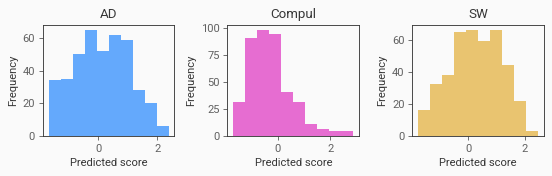

In [7]:
# Plot histogram of scores on each of the three factors in y_pred
f, ax = plt.subplots(1, 3, figsize=(7, 2.3))

# Get the default color cycle
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

for i, factor in enumerate(y_pred.columns):
    ax[i].hist(y_pred[factor], bins=10, color=colors[i], alpha=0.6)
    ax[i].set_title(factor)
    ax[i].set_xlabel("Predicted score")
    ax[i].set_ylabel("Frequency")

plt.tight_layout()

## Export the predicted scores

Finally, we can export the predicted scores on our test data.


In [8]:
# Add subjectID to y_pred
y_pred["subjectID"] = questionnaire_df["subjectID"].reset_index(drop=True)

# Create results/follow-up/transdiagnostic-factors if it doesn't exist
if not os.path.exists("results/follow-up/transdiagnostic-factors"):
    os.makedirs("results/follow-up/transdiagnostic-factors")

# Save to csv
y_pred.to_csv(
    "results/follow-up/transdiagnostic-factors/predicted_factor_scores.csv",
    index=False,
)